In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import PIL
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.losses import categorical_crossentropy
import pandas as pd 
from keras.regularizers import l2
from keras import models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn import linear_model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls "/content/drive/MyDrive/Semester 2 files/EE258/Project EE258 - Dataset"

input  test  test_new  train  train_new


In [5]:
train_set_path = "/content/drive/MyDrive/Semester 2 files/EE258/Project EE258 - Dataset/train_new"
test_set_path = "/content/drive/MyDrive/Semester 2 files/EE258/Project EE258 - Dataset/test_new"

In [6]:
x = plt.imread("/content/drive/MyDrive/Semester 2 files/EE258/Project EE258 - Dataset/test/happy/PrivateTest_1140198.jpg")
x.shape

(48, 48)

In [7]:
image_size = (48, 48) # (width, height)

class_map = {
    'surprise': 0,
    'fear': 1,
    'angry': 2,
    'neutral': 3,
    'sad': 4,
    'disgust': 5,
    'happy': 6
}

random_state = 40

In [8]:
def create_dataset(file_path):
    df = pd.DataFrame()
    
    for cat in os.listdir(file_path):
        image_file = os.listdir(os.path.join(file_path, cat))
        label = [cat] * len(image_file)
        tmp_df = pd.DataFrame([image_file, label]).T
        tmp_df.columns = ['image_file', 'label']
        df = pd.concat([df, tmp_df])
        
    return df

def display_sample_image(img_num=10):
    plt.figure(figsize=(10,5))
    for i, v in train_df.sample(10).reset_index().iterrows():
        label = v.label
        image_file = v.image_file
        path = os.path.join(os.path.join(train_set_path, label), image_file)
        image = cv2.imread(image_file)
        plt.subplot(2,5,i+1)
        plt.grid(False)
        plt.xlabel(label)

        plt.imshow(image)

        
def preprocess_image(image):
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, image_size, interpolation = cv2.INTER_AREA) # resize (48, 48)
    image = np.array(image) # convert pixel to float
    image = image.astype('float32')
    image /= 255 # normalize
    
    return image

def prepare_dataset(df, class_map):
    image_array = []
    class_name = []
    
    for i, row in df.iterrows():
        
        image_path = row.image_file
        image_class = class_map[row.label]
        
        image = cv2.imread(image_path, 0) # load image (0 = grayscale)
        image = preprocess_image(image) # preprocess (resize -> convert pixel to float -> normalize)
        
        image_array.append(image)
        class_name.append(image_class)
        
    return np.array(image_array).reshape((len(image_array), image_size[0], image_size[1], 1)), to_categorical(np.array(class_name))

**Dataset Augmentation, Preprocessing the image**

In [9]:
datagen = ImageDataGenerator(rotation_range = 0,
                             width_shift_range = 0,
                             height_shift_range = 0,
                             rescale = None,
                             shear_range = 0,
                             zoom_range = 0,
                             horizontal_flip = False,
                             fill_mode = 'nearest')

In [10]:
img_height = image_size[1]
img_width = image_size[0]
input_shape = (img_height, img_width, 1)

num_classes = len(class_map)

**A CNN model is defined for this model. With a convolution layer of 32 and 64 feature maps, 3*3 kernel size, acrivation function RELU. Max pooling with 2*2 kernel size. And a dense layer with RELU and SOFTMAX activation functions.**

In [11]:
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPool2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPool2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPool2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    print(model.summary())
    
    return model

In [12]:
batch_size = 128

In [13]:
def train_model(model, train_set, val_set, optimizer, loss, metrics, epochs, batch_size, class_weight, callbacks):
    
    model.compile(optimizer=Adam(lr=1e-3, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(train_set[0], train_set[1],
                    validation_data=(val_set[0], val_set[1]), 
                    epochs=epochs,
                    batch_size=batch_size,
                    class_weight=class_weight,
                    callbacks=callbacks)
    
    return model, history

def plot_trian_history(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [14]:
def plot_image_and_emotion(image, label, prediction):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=False)
    
    bar_label = class_map.keys()
    
    image = np.reshape(image, (image.shape[0], image.shape[1]))
    
    axs[0].imshow(image, "gray")
    axs[0].set_title(label)
    
    axs[1].bar(bar_label, prediction)
    axs[1].grid()
    
    plt.show()

In [15]:
model_list = {
    'model_1': {
        'model': create_model,
        'trained_model': None,
        'history': None,
        'test_acc': None,
        'test_loss': None,
        'prediction': None
    },
  
}

acc_list = {
    'model_1': 0,
}

=============== CREATE DATASET ===============

train set:  (3820, 2)
test set:  (1705, 2)

=============== Prepare Dataset ===============

Train: (3056, 3056)
Validate: (764, 764)
Test: (1705, 1705)

=============== Train Model ===============

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/65
24/24 [==============================] - 10s 369ms/step - loss: 0.3055 - accuracy: 0.3861 - val_loss: 1.7890 - val_accuracy: 0.3861
Epoch 2/65
24/24 [==============================] - 9s 360ms/step - loss: 0.2564 - accuracy: 0.4009 - val_loss: 1.9418 - val_accuracy: 0.3861
Epoch 3/65
24/24 [==============================] - 9s 362ms/step - loss: 0.2537 - accuracy: 0.4009 - val_loss: 1.8651 - val_accuracy: 0.3861
Epoch 4/65
24/24 [==============================] - 9s 362ms/step - loss: 0.2496 - accuracy: 0.4009 - val_loss: 1.9884 - val_accuracy: 0.3861
Epoch 5/65
24/24 [==============================] - 9s 364ms/step - loss: 0.2359 - accuracy: 0.4100 - val_loss: 1.6765 - val_accuracy: 0.4346
Epoch 6/65
24/24 [==============================] - 9s 360ms/step - loss: 0.2269 - accuracy: 0.4332 - val_loss: 1.6656 - val_accuracy: 0.4175
Epoch 7/65
24/24 [==============================] - 9s 362ms/step - loss: 0.2206 - accuracy: 0.4368 - val_loss: 1.6894 - val_accuracy: 0.4319
Epoch

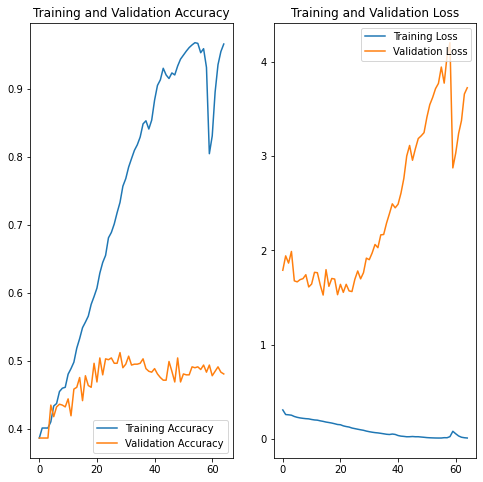

54/54 [==============================] - 1s 25ms/step - loss: 4.7058 - accuracy: 0.3460
[model_1] test accuracy:0.3460410535335541
96/96 [==============================] - 2s 25ms/step - loss: 0.1087 - accuracy: 0.9679
[model_1] train accuracy:0.9679319262504578

=============== Save Trained Model ===============



In [16]:
# 1. Create Dataset
print("=============== CREATE DATASET ===============")
print()
train_df = create_dataset(train_set_path)
train_df["image_file"] = train_df.apply(lambda x : os.path.join(os.path.join(train_set_path, x['label']), x['image_file']), axis=1)

test_df = create_dataset(test_set_path)
test_df["image_file"] = test_df.apply(lambda x : os.path.join(os.path.join(test_set_path, x['label']), x['image_file']), axis=1)

print("train set: ", train_df.shape)
print("test set: ", test_df.shape)

# display_sample_image(img_num=10)

# 2. Prepare Dataset
print()
print("=============== Prepare Dataset ===============")
print()
train_ds, val_ds = train_test_split(train_df, test_size=0.2, random_state=random_state)

X_train, y_train = prepare_dataset(train_ds, class_map)
X_val, y_val = prepare_dataset(val_ds, class_map)
X_test, y_test = prepare_dataset(test_df, class_map)

print("Train: ({}, {})".format(str(len(X_train)), str(len(y_train))))
print("Validate: ({}, {})".format(str(len(X_val)), str(len(y_val))))
print("Test: ({}, {})".format(str(len(X_test)), str(len(y_test))))

# 3. Train Model
print()
print("=============== Train Model ===============")
print()
class_weight = (train_df.label.value_counts() / train_df.shape[0])
class_weight.index = class_weight.index.map(class_map)
class_weight = class_weight.to_dict()

epochs = 65

for m in model_list:
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.1, patience=5)
    model = model_list[m]['model']
    trained_model, history = train_model(model=model(input_shape, num_classes),
                                         train_set=(X_train, y_train),
                                         val_set=(X_val, y_val),
                                         optimizer=Adam(lr=1e-3, decay=1e-6),
                                         loss=categorical_crossentropy,
                                         metrics=['accuracy'],
                                         epochs=epochs,
                                         batch_size=128,
                                         class_weight=class_weight,
                                         callbacks=None)
    
    # keep trained_model, history, prediction
    model_list[m]['trained_model'] = trained_model
    model_list[m]['history'] = history
    model_list[m]['prediction'] = trained_model.predict(X_test)
    
    # plot history
    # plot_trian_history(history, earlystop_callback.stopped_epoch + 1)
    plot_trian_history(history, epochs)
    
    # evaluate
    test_loss, test_acc = trained_model.evaluate(X_test, y_test)
    print('[{}] test accuracy:{}'.format(m, test_acc))
    # keep loss, accuracy
    model_list[m]['test_acc'] = test_acc
    model_list[m]['test_loss'] = test_loss
    acc_list[m] = test_acc
    # evaluate
    train_loss, train_acc = trained_model.evaluate(X_train, y_train)
    print('[{}] train accuracy:{}'.format(m, train_acc))
    # keep loss, accuracy
    model_list[m]['train_acc'] = train_acc
    model_list[m]['train_acc'] = train_acc
    acc_list[m] = train_acc
    
# 4. Save The Best Trained Model
print()
print("=============== Save Trained Model ===============")
print()
# serialize model to JSON
best_model = max(acc_list, key=acc_list.get)
trained_model = model_list[best_model]['trained_model']
model_json = trained_model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
trained_model.save_weights("model.h5")

In [17]:
for m in model_list:
    print("MODEL : {} - ACCURACY : {}".format(m, model_list[m]['train_acc']))
    print("MODEL : {} - ACCURACY : {}".format(m, model_list[m]['test_acc']))

MODEL : model_1 - ACCURACY : 0.9679319262504578
MODEL : model_1 - ACCURACY : 0.3460410535335541


In [18]:
sns.set(font_scale=1.5)
sns.set_style("dark")

In [19]:
def get_test_image(test_image_array, test_image_label, pred_test_labels, image_number):
    image = test_image_array[image_number]
    label = list(class_map.keys())[list(class_map.values()).index(list(test_image_label[image_number]).index(1))]
    prediction = pred_test_labels[image_number]
    
    return image, label, prediction

In [20]:
pred_test_labels = model_list[best_model]['prediction']
test_df.reset_index().sample(10)

index                                         image_file    label
323     142  /content/drive/MyDrive/Semester 2 files/EE258/...  neutral
541      47  /content/drive/MyDrive/Semester 2 files/EE258/...      sad
957     151  /content/drive/MyDrive/Semester 2 files/EE258/...     fear
1544    373  /content/drive/MyDrive/Semester 2 files/EE258/...    happy
712     218  /content/drive/MyDrive/Semester 2 files/EE258/...      sad
486     305  /content/drive/MyDrive/Semester 2 files/EE258/...  neutral
775     281  /content/drive/MyDrive/Semester 2 files/EE258/...      sad
636     142  /content/drive/MyDrive/Semester 2 files/EE258/...      sad
1628     33  /content/drive/MyDrive/Semester 2 files/EE258/...    angry
919     113  /content/drive/MyDrive/Semester 2 files/EE258/...     fear

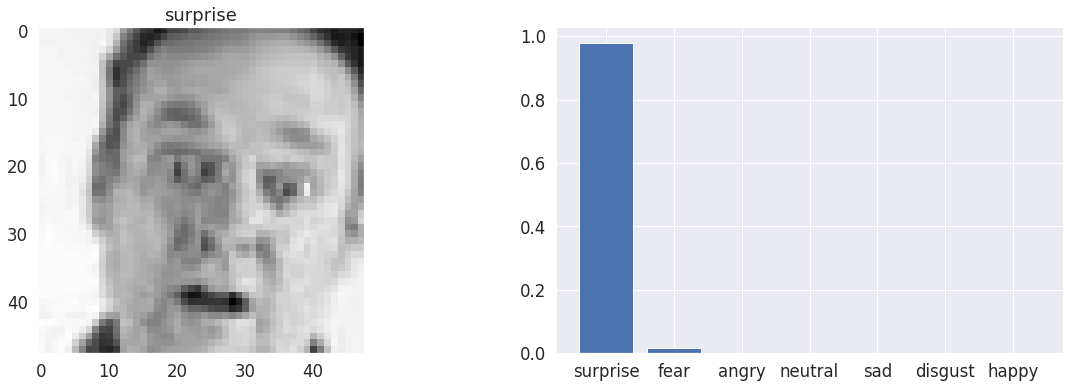

In [21]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=55)
plot_image_and_emotion(image, label, prediction)

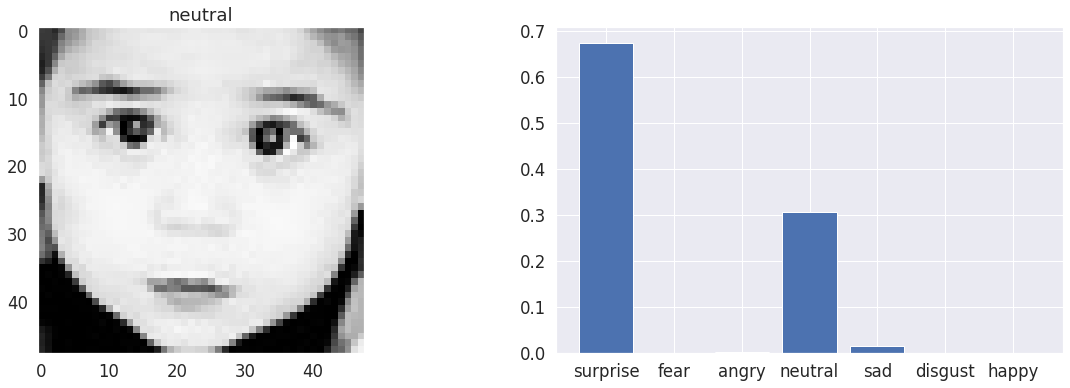

In [22]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=444)
plot_image_and_emotion(image, label, prediction)

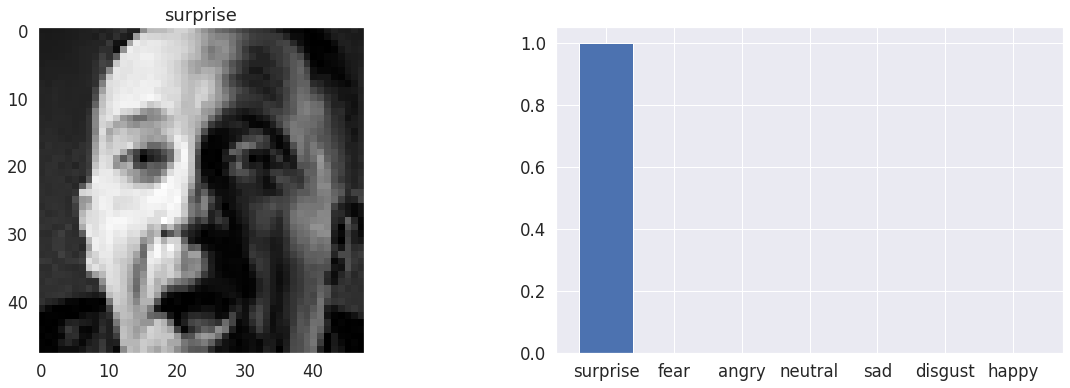

In [23]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=77)
plot_image_and_emotion(image, label, prediction)

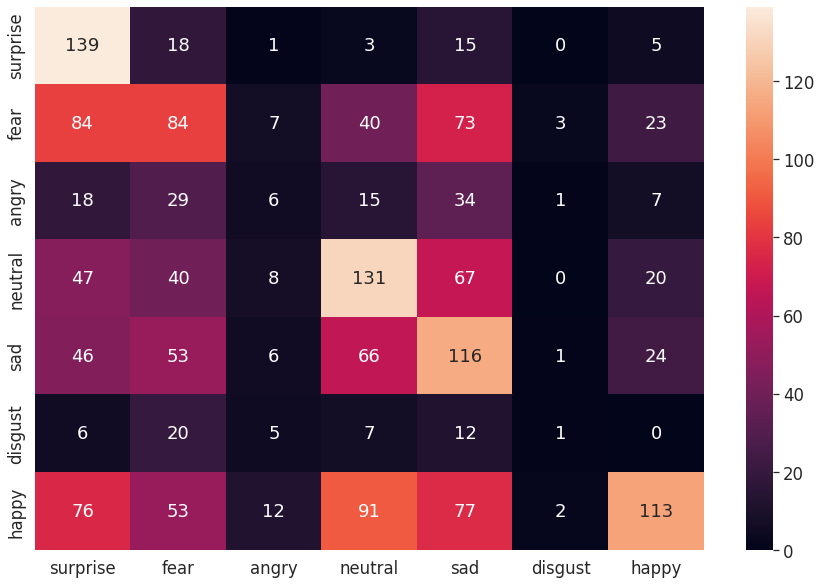

In [24]:
key_list = list(class_map.keys())
val_list = list(class_map.values())
c_matrix = confusion_matrix(y_true=np.argmax(y_test, axis=1).tolist(), 
                            y_pred=np.argmax(pred_test_labels, axis=1).tolist())

plt.subplots(figsize=(15, 10))
sns.heatmap(c_matrix, annot=True,  fmt='d', xticklabels=key_list, yticklabels=key_list)

In [25]:
print(classification_report(y_true=np.argmax(y_test, axis=1).tolist(), 
                            y_pred=np.argmax(pred_test_labels, axis=1).tolist(),
                            target_names=list(class_map.keys())))

              precision    recall  f1-score   support

    surprise       0.33      0.77      0.47       181
        fear       0.28      0.27      0.27       314
       angry       0.13      0.05      0.08       110
     neutral       0.37      0.42      0.39       313
         sad       0.29      0.37      0.33       312
     disgust       0.12      0.02      0.03        51
       happy       0.59      0.27      0.37       424

    accuracy                           0.35      1705
   macro avg       0.30      0.31      0.28      1705
weighted avg       0.37      0.35      0.33      1705

